## **Imports**

In [21]:
from sklearn.preprocessing import RobustScaler, OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, KFold
import pandas as pd
import numpy as np
import re
import optuna
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import itertools
import matplotlib.pyplot as plt
from torch.nn import MSELoss
import shap

## **Data Preprocessing**

In [2]:
# Load the dataset
dataset = pd.read_csv('battery_feature_extracted.csv')

In [3]:
# Select features and target
X = dataset.drop(columns=['average_voltage'])
y = dataset['average_voltage']

In [4]:
# First split to separate out the test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

In [5]:
# Second split: separate the training set into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)  # 20% for validation


In [6]:
# Standardizing the features (fit on X_train, apply to all)
scaler = RobustScaler()
#scaler = StandardScaler()
#scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

In [7]:
# Convert to tensors
X_train_tensor = torch.FloatTensor(X_train_scaled)
y_train_tensor = torch.FloatTensor(y_train.values).unsqueeze(1)  # Ensure target tensor is of the right shape
X_val_tensor = torch.FloatTensor(X_val_scaled)
y_val_tensor = torch.FloatTensor(y_val.values).unsqueeze(1)
X_test_tensor = torch.FloatTensor(X_test_scaled)
y_test_tensor = torch.FloatTensor(y_test.values).unsqueeze(1)

In [8]:
# Model parameters
num_features = X_train_scaled.shape[1]
output_size = 1  # For regression, we predict a single continuous value

# **Load saved model**

In [10]:
# GRU-based submodule
class GRUNetwork(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=1, dropout=0.5):
        super(GRUNetwork, self).__init__()
        self.gru = nn.GRU(input_size, hidden_size, num_layers=num_layers, batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        _, h_n = self.gru(x)
        h_n = h_n[-1]  # Take final hidden state
        return self.fc(h_n)

In [11]:
# TabTransformer with GRU
class TabTransformerWithGRU(nn.Module):
    def __init__(self, num_features, output_size=1, dim_embedding=128, num_heads=2, num_layers=2, gru_hidden_size=128, gru_num_layers=1, gru_dropout=0.5):
        super(TabTransformerWithGRU, self).__init__()
        self.embedding = nn.Linear(num_features, dim_embedding)
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=dim_embedding,
            nhead=num_heads,
            dropout=0.2,
            batch_first=True
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.gru_network = GRUNetwork(
            input_size=dim_embedding,
            hidden_size=gru_hidden_size,
            output_size=output_size,
            num_layers=gru_num_layers,
            dropout=gru_dropout
        )

    def forward(self, x):
        x = self.embedding(x)
        x = x.unsqueeze(1)  # Add sequence dimension
        x = self.transformer(x)
        return self.gru_network(x)

In [12]:
# Define model and move to appropriate device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = TabTransformerWithGRU(num_features=X_train.shape[1]).to(device)

# Load saved weights
model.load_state_dict(torch.load('entire_model_transformer_rnn_gru_mae2765_mse2943_r28877.pth', map_location=device))
model.eval()


C:\Users\Admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn(
C:\Users\Admin\AppData\Local\Temp\ipykernel_3520\3009371891.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless the

TabTransformerWithGRU(
  (embedding): Linear(in_features=3226, out_features=128, bias=True)
  (transformer): TransformerEncoder(
    (layers): ModuleList(
      (0-1): 2 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
        )
        (linear1): Linear(in_features=128, out_features=2048, bias=True)
        (dropout): Dropout(p=0.2, inplace=False)
        (linear2): Linear(in_features=2048, out_features=128, bias=True)
        (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.2, inplace=False)
        (dropout2): Dropout(p=0.2, inplace=False)
      )
    )
  )
  (gru_network): GRUNetwork(
    (gru): GRU(128, 128, batch_first=True, dropout=0.5)
    (fc): Linear(in_features=128, out_features=1, bias=True)
  )
)

In [13]:
with torch.no_grad():
    predictions = model(X_test_tensor.to(device))
    test_mse = nn.MSELoss()(predictions, y_test_tensor.to(device))
    test_mae = nn.L1Loss()(predictions, y_test_tensor.to(device))
    ss_total = torch.sum((y_test_tensor - torch.mean(y_test_tensor))**2)
    ss_residual = torch.sum((y_test_tensor - predictions.cpu())**2)
    r2_score = 1 - (ss_residual / ss_total)

In [14]:
print(f"Test MSE: {test_mse.item():.4f}")
print(f"Test MAE: {test_mae.item():.4f}")
print(f"Test R²: {r2_score.item():.4f}")

Test MSE: 0.2943
Test MAE: 0.2765
Test R²: 0.8877


## **SHAP**

In [15]:
# Initialize model and set to CPU
device = torch.device("cpu")
model = TabTransformerWithGRU(num_features=X_train_scaled.shape[1]).to(device)
model.eval()

TabTransformerWithGRU(
  (embedding): Linear(in_features=3226, out_features=128, bias=True)
  (transformer): TransformerEncoder(
    (layers): ModuleList(
      (0-1): 2 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
        )
        (linear1): Linear(in_features=128, out_features=2048, bias=True)
        (dropout): Dropout(p=0.2, inplace=False)
        (linear2): Linear(in_features=2048, out_features=128, bias=True)
        (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.2, inplace=False)
        (dropout2): Dropout(p=0.2, inplace=False)
      )
    )
  )
  (gru_network): GRUNetwork(
    (gru): GRU(128, 128, batch_first=True, dropout=0.5)
    (fc): Linear(in_features=128, out_features=1, bias=True)
  )
)

In [16]:
# Dummy forward for SHAP
def wrapped_model(x_numpy):
    x_tensor = torch.tensor(x_numpy, dtype=torch.float32).to(device)
    with torch.no_grad():
        return model(x_tensor).cpu().numpy()

In [18]:
# Step 3: Prepare SHAP data
X_train_np = X_train_tensor.cpu().numpy()
X_test_np = X_test_tensor.cpu().numpy()

In [19]:
# SHAP background and sample
# Select background and sample input
background = X_train_np[np.random.choice(X_train_np.shape[0], 100, replace=False)]
X_sample = X_test_np[:50]  # Keep small for speed

In [22]:
# KernelExplainer
explainer = shap.KernelExplainer(wrapped_model, background)
shap_values = explainer.shap_values(X_sample)

  0%|          | 0/50 [00:00<?, ?it/s]

In [25]:
#Feature importance summary
mean_abs_shap = np.abs(shap_values).mean(axis=0).flatten()  # Ensure 1D
top_indices = np.argsort(mean_abs_shap)[-20:][::-1]
feature_names = X.columns.tolist()
top_features = [feature_names[i] for i in top_indices]
top_shap_values = mean_abs_shap[top_indices]

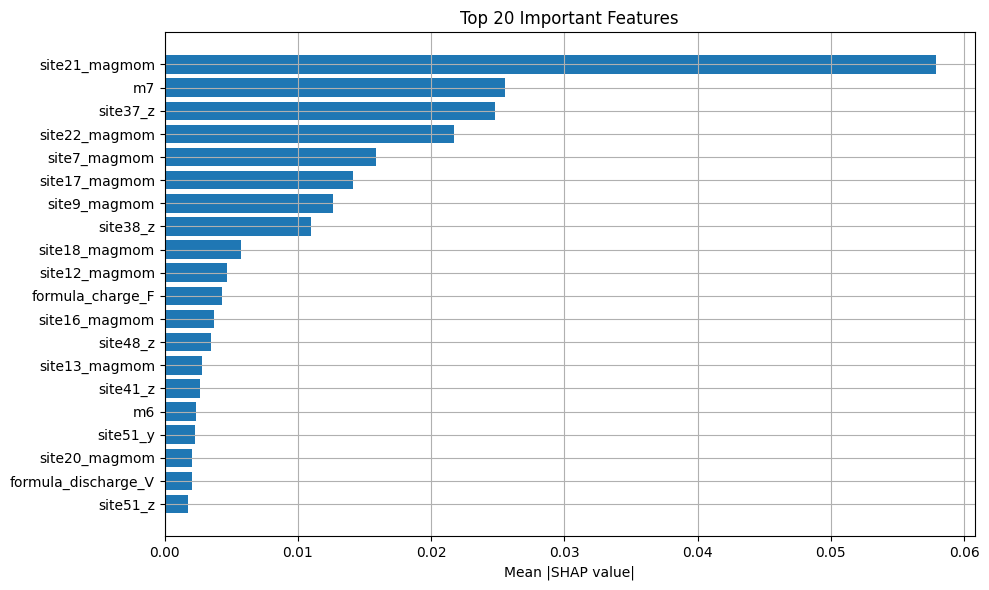

In [26]:
#Plot
plt.figure(figsize=(10, 6))
plt.barh(top_features, top_shap_values)
plt.xlabel("Mean |SHAP value|")
plt.title("Top 20 Important Features")
plt.gca().invert_yaxis()
plt.grid(True)
plt.tight_layout()
plt.show()